# Figure 14: Shapiro-Wilk test

This code is used to create **Figure 14** in the **Apples with Apples** paper (Bonse et al. in prep). The Figure shows the sensitivity of the Shapiro-Wilk test as a function of separation from the star. We study two cases: 
1. The false positive fraction of the Shapiro-Wilk test in case of Gaussian noise.
2. The sensitivity i.e. true positive fractionof the Shapiro-Wilk in case of Laplactian noise.

## Imports

In [1]:
import os
import random
import pickle
import numpy as np
from scipy import stats
from tqdm import tqdm
import seaborn as sns

import matplotlib.pyplot as plt

from applefy.utils.mc_simulations import draw_mc_sample
from applefy.utils.data_handling import read_apples_with_apples_root

## Monte-Carlo Simulation

<div style="text-align: justify">
First we need to run the monte carlo simulation. This step is computationally very expensive. If you just want to reproduce the plot you can skip this part and [restore the results](14_Residual_Shapiro.ipynb#Alternative:-restore-the-results) from Zenodo.
</div>

In [2]:
# Compute the number of independent resolution elements
separations = np.linspace(1, 8, 15)
num_res_elements = [(int(np.floor(np.pi*2*i)), i) for i in separations]

Run the actual monte-carlo simulation.

In [28]:
np.random.seed(42)
num_tests= 1e6

p_values_normal = dict()
p_values_laplace = dict()

for tmp_num_res, tmp_separation in num_res_elements:
    print("Running separation " + str(tmp_separation))
    
    # Draw noise
    _, res_values_normal, _ = draw_mc_sample(
        tmp_num_res,
        num_draws=num_tests,
        noise_distribution="gaussian",
        num_cores=32,
        loc_noise=1,
        scale_noise=1)

    _, res_values_laplace, _ = draw_mc_sample(
        tmp_num_res,
        num_draws=num_tests,
        noise_distribution="laplace",
        num_cores=32,
        loc_noise=1,
        scale_noise=1)
    
    # Compute p-values
    p_values_normal[tmp_separation] = []
    p_values_laplace[tmp_separation] = []

    for i in tqdm(range(int(num_tests))):
        p_values_normal[tmp_separation].append(
            stats.shapiro(res_values_normal[i, :]).pvalue)
        p_values_laplace[tmp_separation].append(
            stats.shapiro(res_values_laplace[i, :]).pvalue)

Running separation 1.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:08<00:00, 14494.54it/s]


Running separation 1.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:10<00:00, 14267.32it/s]


Running separation 2.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:07<00:00, 14758.18it/s]


Running separation 2.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:06<00:00, 14944.03it/s]


Running separation 3.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 670504/1000000 [00:45<00:22, 14707.77it/s]


KeyboardInterrupt: 

Save the results.

In [3]:
result_dir = os.path.join(
    read_apples_with_apples_root(),
    "70_results/shapiro_wilk_tests/")

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


In [ ]:
# Save as .pkl
with open(os.path.join(result_dir, 'A1_Shapiro_normal.pkl'), 'wb') as handle:
    pickle.dump(p_values_normal, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(result_dir, 'A1_Shapiro_laplace.pkl'), 'wb') as handle:
    pickle.dump(p_values_laplace, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Alternative: restore the results

Restore the results of the Monte-Carlo simulation. In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [4]:
result_dir = os.path.join(
    read_apples_with_apples_root(),
    "70_results/shapiro_wilk_tests/")

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


The restored results just contain the p-values of the test for Gaussian noise (false positives) and Laplacian noise (true positives).

In [5]:
# Load .pkl
with open(os.path.join(result_dir, 'A1_Shapiro_normal.pkl'), 'rb') as handle:
    p_values_normal = pickle.load(handle)
    
with open(os.path.join(result_dir, 'A1_Shapiro_laplace.pkl'), 'rb') as handle:
    p_values_laplace = pickle.load(handle)

## Compute FPF and TPF

We compute the false positive fraction (FPF) and true positive fraction (TPF) for two different confidence levels: $p<0.01$ and $p<0.2$.

In [6]:
# FPF
normal_p_001 = [np.sum(np.array(p_values) < 0.01) /
                len(p_values) for p_values in p_values_normal.values()]
# TPF
laplace_p_001 = [np.sum(np.array(p_values) < 0.01) / len(p_values)
                 for p_values in p_values_laplace.values()]

# FPF
normal_p_02 = [np.sum(np.array(p_values) < 0.2) / len(p_values) 
               for p_values in p_values_normal.values()]
# TPF
laplace_p_02 = [np.sum(np.array(p_values) < 0.2) / len(p_values) 
                for p_values in p_values_laplace.values()]

## Make the Plot

Define the colors we want to use for the plot.

In [7]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1]]

A small function to plot the two cases $p<0.01$ and $p<0.2$.

In [8]:
def plot_results(
    axis_in,
    fpf_values,
    tpf_values,
    title):
    
    # Plot the fpf and tpf
    axis_in.plot(
        p_values_normal.keys(),
        fpf_values, 
        lw=3, color=color_palette[0], 
        label="Gaussian Noise")
    
    axis_in.plot(
        p_values_normal.keys(), 
        tpf_values, 
        lw=3, color=color_palette[1], 
        label="Laplacian Noise")
    
    axis_in.grid()
    axis_in.set_ylim(0, 1)
    axis_in.set_xlim(0.5, 8.5)
    axis_in.set_xticks(np.arange(1,9))

    # Change the Labels and ticks
    for tick in axis_in.xaxis.get_major_ticks():
        tick.label1.set_fontsize(12) 

    # second x axis for the number of Resolution elements
    axis_in_2 = axis_in.twiny()
    
    axis_in_2.set_xticks(np.arange(1, 9))
    axis_in_2.tick_params(axis="x",direction="in", pad=-45)
    
    axis_in_2.set_xticklabels(
        [i[1] for i in num_res_elements][::2], fontsize=12)
    axis_in_2.set_xlim(0.5, 8.5)
    
    for tmp_label in axis_in_2.xaxis.get_ticklabels():
        tmp_label.set_bbox(dict(facecolor='white', edgecolor='none'))
        
    axis_in_2.text(
        1.3, 0.87, "# Resolution elements", 
        bbox=dict(facecolor='white', edgecolor='none'),
        fontsize=14) 

    axis_in.set_title(title, fontsize=14, y=1.02)
    axis_in.set_xlabel(r"Separation $[FWHM]$", fontsize=14)

Create the actual plot.

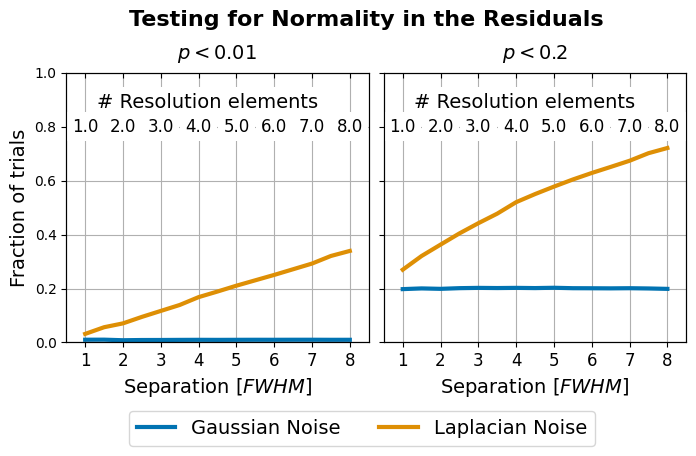

In [9]:
# 1.) Create the Figure Layout
fig = plt.figure(constrained_layout=False, 
                 figsize=(8, 3.5))

gs0 = fig.add_gridspec(1, 2)
gs0.update(hspace=0.1, wspace=0.05)

low = fig.add_subplot(gs0[0, 0])
high = fig.add_subplot(gs0[0, 1], 
                       sharey=low, sharex=low)

# 2.) Plot 1: p < 0.01
plot_results(
    axis_in=low,
    fpf_values=normal_p_001,
    tpf_values=laplace_p_001,
    title=r"$p < 0.01$")
low.set_ylabel("Fraction of trials", fontsize=14)

# 3.) Plot 2: p < 0.2
plot_results(
    axis_in=high,
    fpf_values=normal_p_02,
    tpf_values=laplace_p_02,
    title=r"$p < 0.2$")

plt.setp(high.get_yticklabels(), visible=False)

# 4.) Legend
lgd = low.legend(loc='center right',ncol=2,
                 bbox_to_anchor=(1.78, -0.32),
                 fontsize=14,
                 markerscale=3.,)

fig_title = fig.suptitle(
    "Testing for Normality in the Residuals",
    size=16, fontweight="bold", y=1.06)

fig.patch.set_facecolor('white')
plt.savefig("./14_Residual_Shapiro.pdf", 
            bbox_extra_artists=(lgd, fig_title),
            bbox_inches='tight')